## Motivation 

I (Ben Hudson) am stubborn when it comes to geographic data. I believe that data should be visualized and analysed at the scale it is collected at. However, often the data overwhelms the processing capabilities of scientists. At other times, it doesn't need to be analysed at that extreme scale. 

That said, with a wealth earth observing satellites, envirnmental sensors, and tools such as [LiDAR](https://en.wikipedia.org/wiki/Lidar), scientists often have more data than they know what to do with. Outside of academia, location data can be even more massive, such cell phone location data. This stubborness is why I get excited when I come across tools that let me interact with data at the scale it was actually collected at- tools like [dataShader](https://github.com/bokeh/datashader).To explore this type of data, I am using [marine AIS vessel location data](http://marinecadastre.gov/ais/), from the U.S. Coast Guard. 

I came across it when I was exploring a very basic question - where should I go kayaking if I don't want to get run over or massively waked out by marine traffic in Puget Sound? This data is perhaps not truely 'big', but one month takes up about 800 mb when zipped, and it takes arcGIS a long time to load (which might be a working definition of big data for [GIS](https://en.wikipedia.org/wiki/Geographic_information_system)  folks.) It  represents about 23 million point locations. 

## INSTALLATION 

To install on your local environemnt, run in a terminal 

```
conda install -c bokeh datashader 
```

you may need to also do

```
pip install pyproj
```

Autotime is something I find handy - it times each cell block 
to install it you use this magic command 

```
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
```
[Auto time website](https://github.com/cpcloud/ipython-autotime)


In [1]:
%load_ext autotime
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['agg.path.chunksize'] = 10000

from __future__ import division

from pyproj import Proj, transform

## The old way

As I said at the start, the standard way to handle this data is to plot your program in a [geographic information system](https://en.wikipedia.org/wiki/Geographic_information_system) such as arcGIS. This route is painful and makes the data very hard to quickly explore. Each data point is individually drawn. If you move the area of interest even a little bit, ArcGIS trys to re-draw everything again. QGIS is a little better (it draws the points much more quickly - but suffers from the same issues. Enter Bokeh and DataShader. 

<img src="figures/oldwayGIS.png"> 

## The new way 

First, you need to install bokeh and datashader, then import them


In [2]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

from IPython.core.display import HTML, display

from bokeh.plotting import figure, output_notebook, output_file, show
from bokeh.tile_providers import STAMEN_TERRAIN
from bokeh.tile_providers import STAMEN_TONER
from bokeh.embed import file_html

from functools import partial

output_notebook()

Loading BokehJS ...

time: 3.31 s


## Preliminary Steps - Convert data into a better format
The data was donwloaed from [marinecadastre.gov](http://marinecadastre.gov/ais/). It is formatted as .gdb. Step one is to convert it to something more flexible. To do so, I use the built in tools QGIS has take a .gdb and save it both a .csv and and .geoJson. These files are big, but they are a start.

| data type     | size (GB)     | 
| ------------- |:-------------:| 
| ucompressed GDB      | 2.65 | 
| CSV     | 2.35      | 
| geoJSON |7.95      |


In [3]:
# CSV is much quicker in this case than geojson
df = pd.read_csv('../data/Zone10_WA_2014_07_01.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)



time: 1.95 s


# Re-project

You can use dataShader and Bokeh with any type of point data you want. It does not need to be geographically aware. But to put it in context, it is helpful to plot it on a basemap. In our case - the basemap needs point data in a web mercator projection. 


[Pyproj](https://github.com/jswhit/pyproj) is used to reproject the data 

In [4]:
# Datashader needs the location in web mercator coordiates
    
# WGS 84
inProj = Proj(init='epsg:4326')

# Web mercator
outProj = Proj(init='epsg:3857')

df['xWeb'],df['yWeb'] = transform(inProj,outProj,df['X'].values,df['Y'].values)

time: 207 ms


In [5]:
# Check to see how the coversion went
df['xWeb'][1]

-13708013.675921824

time: 46.6 ms


## Working with time slices

The direct import of the csv to pandas does not handle the data information correctly, so I correct it here. You can also slice the data to within a smaller date and time window if you like.

In [6]:
# set baseDateTime to a proper pandas datetime
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

# this makes it the index 
df.index = pd.to_datetime(df.BaseDateTime, unit='s')

time: 234 ms


## Spatial subset of the data

In [7]:
# Port of Seattle 
df_seattle = df[(df['X'] > -122.385879) & (df['X'] < -122.332153) & (df['Y'] > 47.545195) & (df['Y'] < 47.599191)]

# Port of Tacoma 
df_tacoma = df[(df['X'] > -122.506484) & (df['X'] < -122.353312) & (df['Y'] > 47.222576) & (df['Y'] < 47.301026)]

time: 237 ms


In [8]:
# Resample 
hourly = df.resample('h').count()
df_seattle_hourly = df_seattle.resample('h').count() 
df_tacoma_hourly = df_tacoma.resample('h').count() 

time: 468 ms


# Hourly Shipping variability

The Port of Tacoma's region of interest is visited by similar volumes of ship traffic 

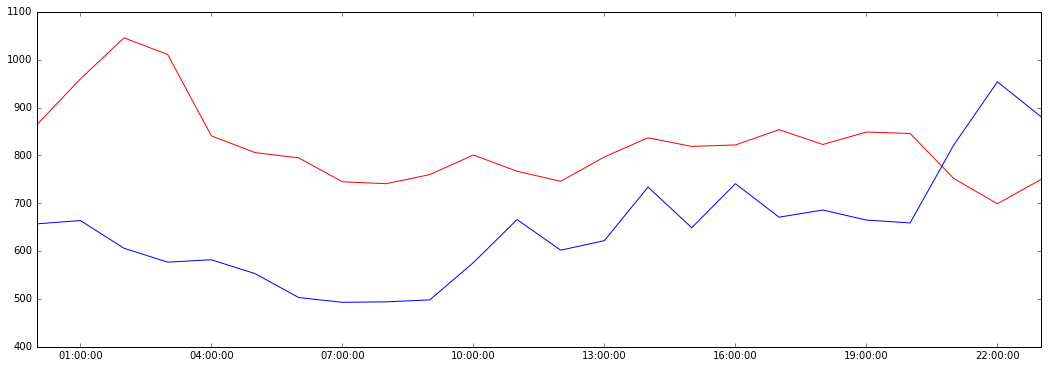

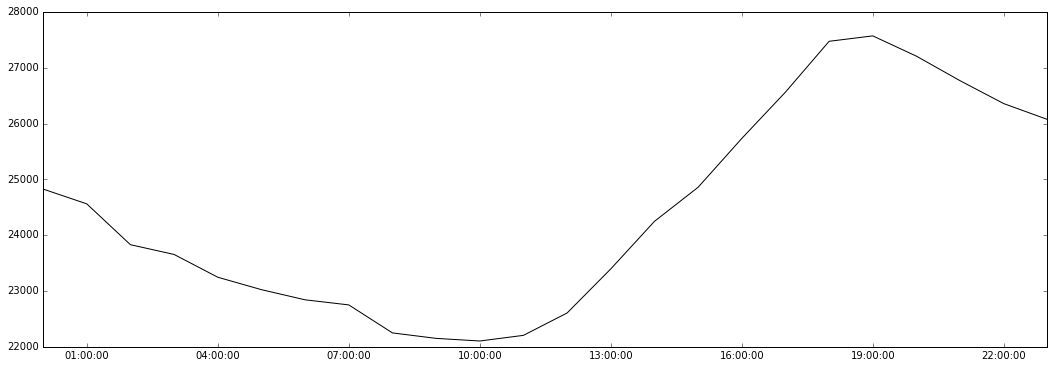

time: 2.24 s


In [9]:
plt.figure(1)
plt.plot(df_tacoma_hourly['X'],'r')
plt.plot(df_seattle_hourly['X'])

plt.figure(2)
plt.plot(hourly['X'],'k')

## And finally the magic 

This is a gif of what you should be getting at the end of this code block. 

<img src="figures/dataShader.gif">

In [10]:
WA = x_range, y_range = ((df.xWeb.min(),df.xWeb.max()), (4898057.594904038,5565974.539663678))

plot_width  = int(600)
plot_height = int(plot_width//1.2)

# This is a useful function to do the heavy lifting
def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'xWeb', 'yWeb',ds.mean('SOG'))
    
    img = tf.shade(agg, cmap=['lightblue','red'], how='eq_hist')
    
    #img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot()
p.add_tile(STAMEN_TERRAIN)


time: 237 ms


In [11]:
#export(create_image(*WA),"WA_red")
InteractiveImage(p, create_image)

time: 4.03 s
